In [76]:
# imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings

In [77]:
# define the path where the data is persisted
STORAGE_PATH = "../../persisted_data/feather/{}.feather"

In [78]:
# load some stock data
value_stock = pd.read_feather(STORAGE_PATH.format("IBM_normalized"))
growth_stock = pd.read_feather(STORAGE_PATH.format("AAPL_normalized"))

In [155]:
# a function measuring the performance of any trading rule
# the provided trading rule must return the position in the stock for each time point
def simulate_performance(stock, rule):
    # get the size of the chart data
    size = stock.shape[0]
    # get the position based on any trading rule
    position = rule(stock)
    # calculate the price changes considering the chosen position
    price_changes = np.diff(stock["current_price"]) / stock["current_price"][:size - 1]
    position_changes = position[:size - 1] * price_changes

    # update the value of the portfolio iteratively
    position_total = np.zeros(size) + stock["current_price"][0]
    for index in range(size - 1):
        position_total[index + 1] = position_total[index]  * (1 + position_changes[index])
    
    return position, position_total

In [156]:
def plot_performance(strategies):
    plt.figure(figsize=(15,8))
    for name, performance in strategies.items():
        plt.plot(np.arange(len(performance)), performance, label=name)
    
    plt.title("Performance comparison of multiple trading strategies")
    plt.legend()
    plt.xlabel("Trading days")
    plt.ylabel("Portfolio change")
    plt.show()

In [157]:
# abstract definition of a regulating speculator
# the trading rule is constructed using the indicators, which are considered
def _regulating_speculator(stock, indicators, min_position=0, max_position=1):
    # a nanmean of an empty slice triggers a warning, but returns nan, which is correct
    warnings.simplefilter("ignore", category=RuntimeWarning)
    # get the indicator data
    indicator_values = stock[indicators]
    
    # calculate the mean, if possible
    mean_features = np.nanmean(indicator_values, axis=1)
    
    # the rule causes a higher position in the stock, if the indicators are low (potentially underpriced)
    rule = 1 - np.where(np.isnan(mean_features), 0, mean_features)
    
    # clip the resulting rule 
    return np.clip(rule, min_position, max_position)

In [158]:
# define multiple regulating speculators based on different indicators

def bollinger_speculator(stock):
    bollinger_indicators = indicators_bollinger = ["bollinger_position20_2", "bollinger_position50_2", "bollinger_position100_2", "bollinger_position200_2"]
    return _regulating_speculator(stock, bollinger_indicators, 0, 1)

def support_resistance_speculator(stock):
    horizontal_indicators = ["horizontal_position20", "horizontal_position50", "horizontal_position100", "horizontal_position200"]
    return _regulating_speculator(stock, horizontal_indicators, 0, 1)

def regression_speculator(stock):
    horizontal_indicators = ["regression_position20", "regression_position50", "regression_position100", "regression_position200"]
    return _regulating_speculator(stock, horizontal_indicators, 0, 1)

def mixed_speculator(stock):
    mixed_indicators = ["bollinger_position50_2", "horizontal_position100", "regression_position100"]
    return _regulating_speculator(stock, mixed_indicators, 0, 1)


In [159]:
# define the trend follower strategy
def _trend_follower(stock, trend):
    return np.clip(np.where(np.isnan(stock[trend]), 1, stock[trend]), 0, 1)


In [165]:
def trend50_200(stock):
    trend_indicator = "ma_trend50_200"
    return _trend_follower(stock, trend_indicator)

def trend20_50(stock):
    trend_indicator = "ma_trend20_50"
    return _trend_follower(stock, trend_indicator)

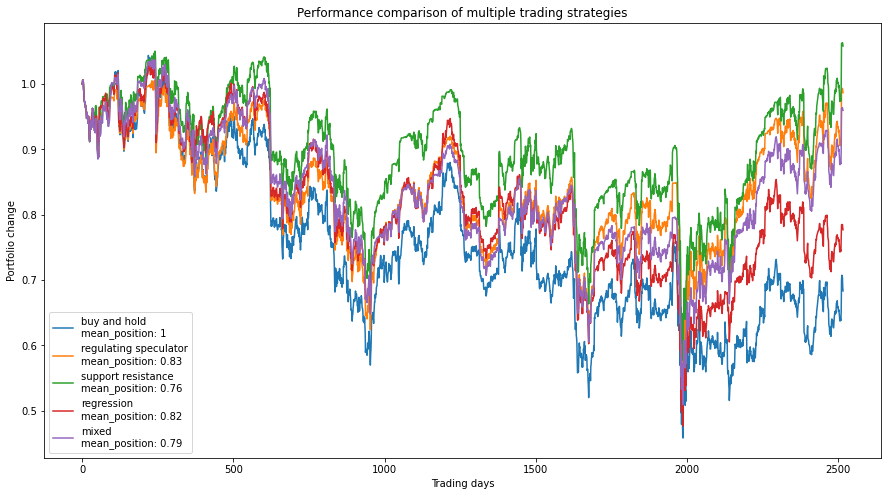

In [161]:
# calculate the performance of all the strategies
bollinger_strategy, bollinger_performance = simulate_performance(value_stock, bollinger_speculator)
bollinger_strategy_mean = np.mean(bollinger_strategy)

support_resistance_strategy, support_resistance_performance = simulate_performance(value_stock, support_resistance_speculator)
support_resistance_strategy_mean = np.mean(support_resistance_strategy)

regression_strategy, regression_performance = simulate_performance(value_stock, regression_speculator)
regression_strategy_mean = np.mean(regression_strategy)

mixed_strategy, mixed_performance = simulate_performance(value_stock, mixed_speculator)
mixed_strategy_mean = np.mean(mixed_strategy)

performances = {
    "buy and hold\nmean_position: {}".format(1): value_stock["current_price"],
    "regulating speculator\nmean_position: {:.2f}".format(bollinger_strategy_mean): bollinger_performance,
    "support resistance\nmean_position: {:.2f}".format(support_resistance_strategy_mean): support_resistance_performance,
    "regression\nmean_position: {:.2f}".format(regression_strategy_mean): regression_performance,
    "mixed\nmean_position: {:.2f}".format(mixed_strategy_mean): mixed_performance
}

plot_performance(performances)

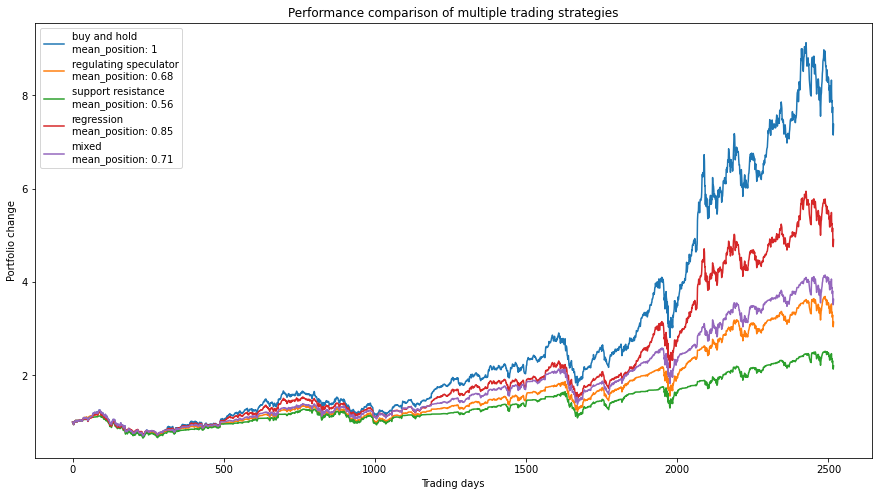

In [162]:
# calculate the performance of all the strategies
bollinger_strategy, bollinger_performance = simulate_performance(growth_stock, bollinger_speculator)
bollinger_strategy_mean = np.mean(bollinger_strategy)

support_resistance_strategy, support_resistance_performance = simulate_performance(growth_stock, support_resistance_speculator)
support_resistance_strategy_mean = np.mean(support_resistance_strategy)

regression_strategy, regression_performance = simulate_performance(growth_stock, regression_speculator)
regression_strategy_mean = np.mean(regression_strategy)

mixed_strategy, mixed_performance = simulate_performance(growth_stock, mixed_speculator)
mixed_strategy_mean = np.mean(mixed_strategy)

performances = {
    "buy and hold\nmean_position: {}".format(1): growth_stock["current_price"],
    "regulating speculator\nmean_position: {:.2f}".format(bollinger_strategy_mean): bollinger_performance,
    "support resistance\nmean_position: {:.2f}".format(support_resistance_strategy_mean): support_resistance_performance,
    "regression\nmean_position: {:.2f}".format(regression_strategy_mean): regression_performance,
    "mixed\nmean_position: {:.2f}".format(mixed_strategy_mean): mixed_performance
}

plot_performance(performances)

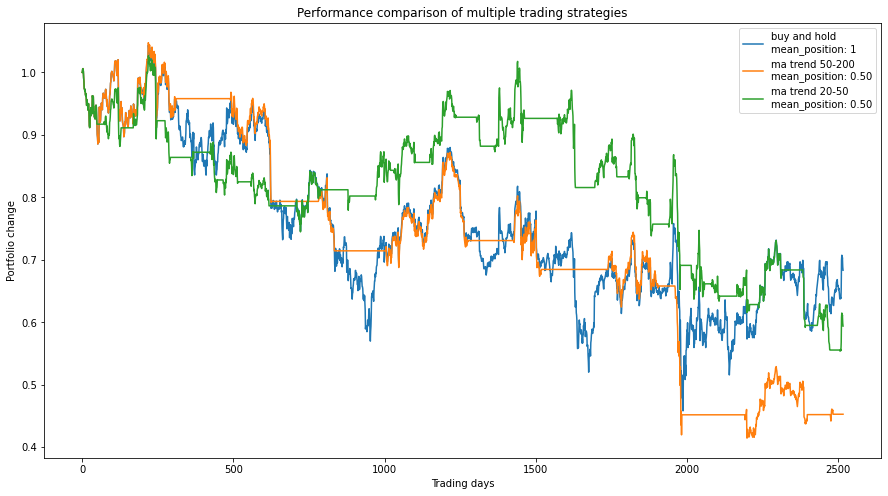

In [166]:
# calculate the performance of all the strategies
trend50_200_strategy, trend50_200_performance = simulate_performance(value_stock, trend50_200)
trend50_200_strategy_mean = np.mean(trend50_200_strategy)

trend20_50_strategy, trend20_50_performance = simulate_performance(value_stock, trend20_50)
trend20_50_strategy_mean = np.mean(trend20_50_strategy)

performances = {
    "buy and hold\nmean_position: {}".format(1): value_stock["current_price"],
    "ma trend 50-200 \nmean_position: {:.2f}".format(trend50_200_strategy_mean): trend50_200_performance,
    "ma trend 20-50 \nmean_position: {:.2f}".format(trend20_50_strategy_mean): trend20_50_performance
}

plot_performance(performances)

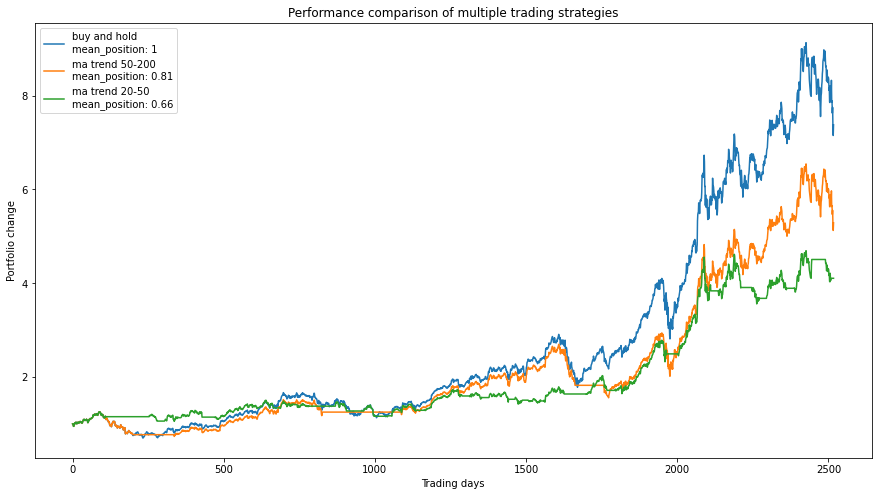

In [167]:
# calculate the performance of all the strategies
trend50_200_strategy, trend50_200_performance = simulate_performance(growth_stock, trend50_200)
trend50_200_strategy_mean = np.mean(trend50_200_strategy)

trend20_50_strategy, trend20_50_performance = simulate_performance(growth_stock, trend20_50)
trend20_50_strategy_mean = np.mean(trend20_50_strategy)

performances = {
    "buy and hold\nmean_position: {}".format(1): growth_stock["current_price"],
    "ma trend 50-200 \nmean_position: {:.2f}".format(trend50_200_strategy_mean): trend50_200_performance,
    "ma trend 20-50 \nmean_position: {:.2f}".format(trend20_50_strategy_mean): trend20_50_performance
}

plot_performance(performances)